In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataframe = pandas.read_csv('cgm_max.csv',  engine='python')

In [3]:
dataframe.head()

NameError: name 'dataframe' is not defined

In [2]:
dataframe["t-1"] = dataframe["cgmtime"].shift(1)
dataframe.head()

NameError: name 'dataframe' is not defined

In [1]:
10019001749 - 10019001817

-68

In [4]:
dataset = dataframe.copy()

In [5]:
dataset.rename(columns={"Historic_ Glucose" : "glucose"} , inplace=True)

In [6]:
dataset = dataset.set_index("cgmdate")
dataset = dataset[["glucose"]]

In [7]:
import pandas as pd
dataset_ = pd.DataFrame(dataset.groupby('cgmdate').glucose.mean())

In [8]:
dataset_.head()

,glucose
cgmdate,
2017-10-01,81.125000
2017-10-02,160.236364
2017-10-03,149.301887
2017-10-04,127.736364
2017-10-05,150.759615


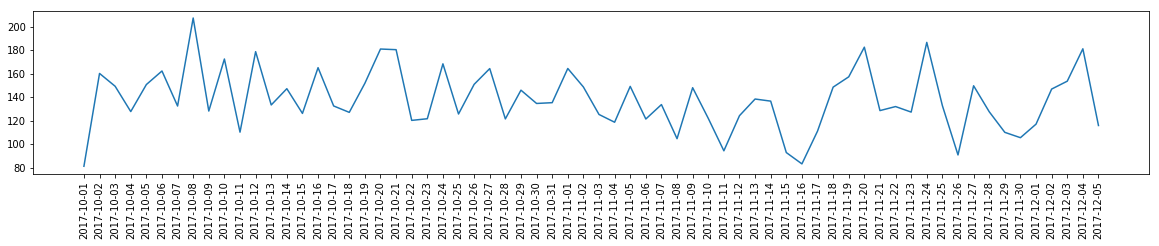

In [9]:
plt.figure(figsize=(20,3))
plt.plot(dataset_)
plt.xticks(rotation='vertical')
plt.show()

In [10]:
dataset_.shape

(66, 1)

In [11]:
dataset = dataset_.copy()
dataset = dataset_.astype('float32')


In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

44 22


In [14]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
print(trainX[:3])
print(trainY[:3])

[[0.        ]
 [0.62614241]
 [0.53959933]]
[0.62614241 0.53959933 0.36891483]


In [17]:
(trainX.shape , trainY.shape)

((42, 1), (42,))

In [18]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
trainX.shape , testX.shape ,trainY.shape

((42, 1, 1), (20, 1, 1), (42,))

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 2s - loss: 0.2771
Epoch 2/100
 - 0s - loss: 0.2029
Epoch 3/100
 - 0s - loss: 0.1452
Epoch 4/100
 - 0s - loss: 0.1032
Epoch 5/100
 - 0s - loss: 0.0731
Epoch 6/100
 - 0s - loss: 0.0548
Epoch 7/100
 - 0s - loss: 0.0446
Epoch 8/100
 - 0s - loss: 0.0403
Epoch 9/100
 - 0s - loss: 0.0378
Epoch 10/100
 - 0s - loss: 0.0374
Epoch 11/100
 - 0s - loss: 0.0369
Epoch 12/100
 - 0s - loss: 0.0368
Epoch 13/100
 - 0s - loss: 0.0365
Epoch 14/100
 - 0s - loss: 0.0363
Epoch 15/100
 - 0s - loss: 0.0361
Epoch 16/100
 - 0s - loss: 0.0360
Epoch 17/100
 - 0s - loss: 0.0358
Epoch 18/100
 - 0s - loss: 0.0358
Epoch 19/100
 - 0s - loss: 0.0356
Epoch 20/100
 - 0s - loss: 0.0356
Epoch 21/100
 - 0s - loss: 0.0353
Epoch 22/100
 - 0s - loss: 0.0354
Epoch 23/100
 - 0s - loss: 0.0351
Epoch 24/100
 - 0s - loss: 0.0351
Epoch 25/100
 - 0s - loss: 0.0351
Epoch 26/100
 - 0s - loss: 0.0349
Epoch

In [21]:
trainY

array([0.62614241, 0.53959933, 0.36891483, 0.55113684, 0.64256985,
       0.40629666, 1.        , 0.37246706, 0.72342123, 0.23010487,
       0.77302564, 0.41350631, 0.52321355, 0.35645548, 0.66504647,
       0.4067615 , 0.36357269, 0.55975284, 0.79074639, 0.78641405,
       0.30942508, 0.32059322, 0.69092588, 0.35250768, 0.55251675,
       0.65885889, 0.31942823, 0.5132261 , 0.42359823, 0.42890371,
       0.65955802, 0.53477474, 0.34936793, 0.2969949 , 0.53880817,
       0.3187079 , 0.41604861, 0.18603203, 0.52989834, 0.32322278,
       0.10428696, 0.34117474])

In [22]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.80 RMSE
Test Score: 32.46 RMSE


In [23]:
dataset_.head()

,glucose
cgmdate,
2017-10-01,81.125000
2017-10-02,160.236364
2017-10-03,149.301887
2017-10-04,127.736364
2017-10-05,150.759615


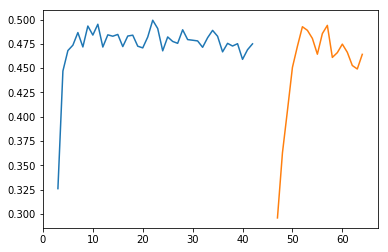

In [31]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset_)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset_)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset_))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

LSTM for Regression Using the Window Method


In [25]:
dataset.shape , dataset_.shape

((66, 1), (66, 1))

Epoch 1/100
 - 1s - loss: 0.2738
Epoch 2/100
 - 0s - loss: 0.2072
Epoch 3/100
 - 0s - loss: 0.1546
Epoch 4/100
 - 0s - loss: 0.1090
Epoch 5/100
 - 0s - loss: 0.0727
Epoch 6/100
 - 0s - loss: 0.0511
Epoch 7/100
 - 0s - loss: 0.0413
Epoch 8/100
 - 0s - loss: 0.0374
Epoch 9/100
 - 0s - loss: 0.0365
Epoch 10/100
 - 0s - loss: 0.0360
Epoch 11/100
 - 0s - loss: 0.0362
Epoch 12/100
 - 0s - loss: 0.0358
Epoch 13/100
 - 0s - loss: 0.0357
Epoch 14/100
 - 0s - loss: 0.0360
Epoch 15/100
 - 0s - loss: 0.0354
Epoch 16/100
 - 0s - loss: 0.0355
Epoch 17/100
 - 0s - loss: 0.0353
Epoch 18/100
 - 0s - loss: 0.0354
Epoch 19/100
 - 0s - loss: 0.0354
Epoch 20/100
 - 0s - loss: 0.0351
Epoch 21/100
 - 0s - loss: 0.0350
Epoch 22/100
 - 0s - loss: 0.0351
Epoch 23/100
 - 0s - loss: 0.0350
Epoch 24/100
 - 0s - loss: 0.0348
Epoch 25/100
 - 0s - loss: 0.0347
Epoch 26/100
 - 0s - loss: 0.0351
Epoch 27/100
 - 0s - loss: 0.0349
Epoch 28/100
 - 0s - loss: 0.0346
Epoch 29/100
 - 0s - loss: 0.0347
Epoch 30/100
 - 0s - lo

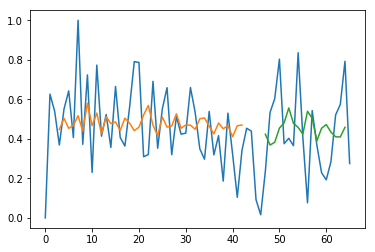

In [26]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataset.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()





LSTM for Regression with Time Steps


In [27]:

# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [28]:
trainX[0]

array([[0.       ],
       [0.6261424],
       [0.5395993]], dtype=float32)

Epoch 1/100
 - 1s - loss: 0.1737
Epoch 2/100
 - 1s - loss: 0.1056
Epoch 3/100
 - 0s - loss: 0.0668
Epoch 4/100
 - 1s - loss: 0.0465
Epoch 5/100
 - 1s - loss: 0.0384
Epoch 6/100
 - 0s - loss: 0.0368
Epoch 7/100
 - 0s - loss: 0.0370
Epoch 8/100
 - 0s - loss: 0.0364
Epoch 9/100
 - 0s - loss: 0.0364
Epoch 10/100
 - 1s - loss: 0.0364
Epoch 11/100
 - 1s - loss: 0.0368
Epoch 12/100
 - 1s - loss: 0.0364
Epoch 13/100
 - 1s - loss: 0.0363
Epoch 14/100
 - 1s - loss: 0.0368
Epoch 15/100
 - 0s - loss: 0.0361
Epoch 16/100
 - 1s - loss: 0.0362
Epoch 17/100
 - 1s - loss: 0.0361
Epoch 18/100
 - 0s - loss: 0.0363
Epoch 19/100
 - 1s - loss: 0.0362
Epoch 20/100
 - 0s - loss: 0.0360
Epoch 21/100
 - 0s - loss: 0.0359
Epoch 22/100
 - 0s - loss: 0.0362
Epoch 23/100
 - 0s - loss: 0.0359
Epoch 24/100
 - 1s - loss: 0.0358
Epoch 25/100
 - 1s - loss: 0.0358
Epoch 26/100
 - 0s - loss: 0.0363
Epoch 27/100
 - 1s - loss: 0.0362
Epoch 28/100
 - 0s - loss: 0.0358
Epoch 29/100
 - 0s - loss: 0.0359
Epoch 30/100
 - 0s - lo

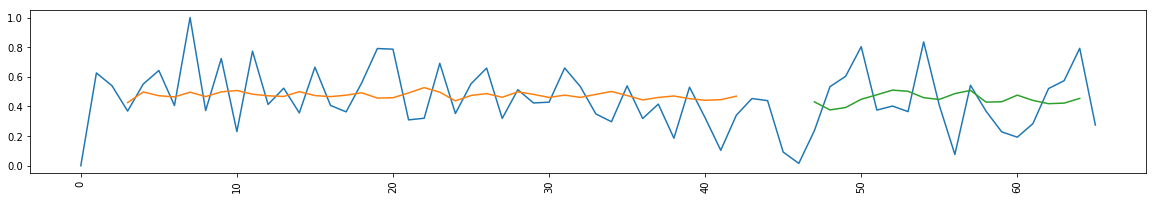

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,3))
plt.xticks(rotation='vertical')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Epoch 1/1
 - 1s - loss: 0.1018
Epoch 1/1
 - 0s - loss: 0.0531
Epoch 1/1
 - 0s - loss: 0.0409
Epoch 1/1
 - 0s - loss: 0.0387
Epoch 1/1
 - 0s - loss: 0.0382
Epoch 1/1
 - 0s - loss: 0.0380
Epoch 1/1
 - 0s - loss: 0.0379
Epoch 1/1
 - 0s - loss: 0.0378
Epoch 1/1
 - 0s - loss: 0.0377
Epoch 1/1
 - 0s - loss: 0.0376
Epoch 1/1
 - 0s - loss: 0.0375
Epoch 1/1
 - 0s - loss: 0.0375
Epoch 1/1
 - 0s - loss: 0.0374
Epoch 1/1
 - 0s - loss: 0.0373
Epoch 1/1
 - 0s - loss: 0.0372
Epoch 1/1
 - 0s - loss: 0.0371
Epoch 1/1
 - 0s - loss: 0.0371
Epoch 1/1
 - 0s - loss: 0.0370
Epoch 1/1
 - 0s - loss: 0.0369
Epoch 1/1
 - 0s - loss: 0.0369
Epoch 1/1
 - 0s - loss: 0.0368
Epoch 1/1
 - 0s - loss: 0.0368
Epoch 1/1
 - 0s - loss: 0.0367
Epoch 1/1
 - 0s - loss: 0.0367
Epoch 1/1
 - 0s - loss: 0.0366
Epoch 1/1
 - 0s - loss: 0.0366
Epoch 1/1
 - 0s - loss: 0.0365
Epoch 1/1
 - 0s - loss: 0.0365
Epoch 1/1
 - 0s - loss: 0.0364
Epoch 1/1
 - 0s - loss: 0.0364
Epoch 1/1
 - 0s - loss: 0.0363
Epoch 1/1
 - 0s - loss: 0.0363
Epoch 1/

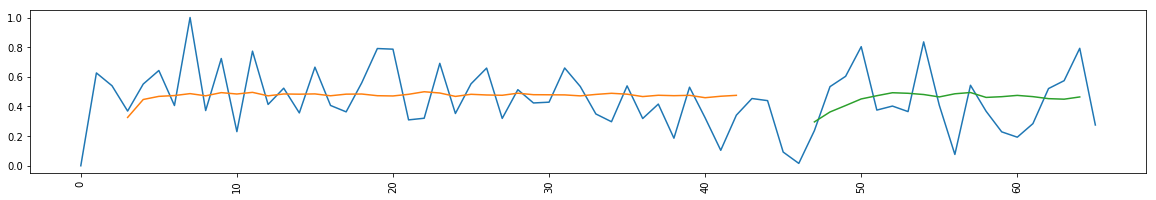

In [30]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

plt.figure(figsize=(20,3))
plt.xticks(rotation='vertical')

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()